# Tobig's 14기 6주차 Neural Network Assignment2
### Made by 이지용

In [1]:
import numpy as np
from matplotlib import pyplot as plt

## 데이터 불러오기

학습에 쓰일 데이터는 keras의 cifar-10 데이터입니다.  
32x32 이미지에 색상을 rgb 3가지로 분류한 데이터로 총 3072 차원입니다.  
이 이미지를 10가지 카테고리로 분류했습니다.  
https://www.cs.toronto.edu/~kriz/cifar.html

In [2]:
x_train = np.load("./x_train_data.npy")
y_train = np.load("./y_train_data.npy")
x_test = np.load("./x_test_data.npy")
y_test = np.load("./y_test_data.npy")

In [3]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5000, 3072), (5000,), (1000, 3072), (1000,))

## 활성화 함수 클래스

신경망에 사용될 함수들을 정의합니다.

### Activation Functions

In [4]:
class sigmoid :
    # sigmoid 함수입니다.
    def forward(z) :
        c = np.max(z)/2
        return np.exp(c)/(np.exp(c)+np.exp(-z+c))
    
    # sigmoid 함수의 미분을 작성하세요
    def backward(a) :
        return a*(1-a)

In [5]:
z = np.array([-1,2,3])

In [6]:
sigmoid.forward(z)

array([0.26894142, 0.88079708, 0.95257413])

In [7]:
sigmoid.backward(z)

array([-2, -2, -6])

In [8]:
class relu :
    # relu 함수를 작성하세요
    def forward(z) :
        return np.maximum(z,0)
    
    # relu 함수의 미분을 작성하세요
    def backward(a) :
        f = np.vectorize(lambda x: 1. if x>=0 else 0.)
        return f(a)

In [9]:
relu.forward(z)

array([0, 2, 3])

In [10]:
relu.backward(z)

array([0., 1., 1.])

### Output Activation Function

softmax는 overflow 문제와 차원 문제 때문에 작성해두었습니다.
이 부분은 softmax overflow문제에 대해 검색해보세요.

In [11]:
class softmax :
    def forward(z) :
        y = []
        for zi in z :
            #print("z", z[0])
            c = np.max(zi)
            exp_zi = np.exp(zi-c)
            sum_exp_zi = np.sum(exp_zi)
            yi = exp_zi / sum_exp_zi
            y.append(yi)
            #print("y", y[0])
        #print(y[0])
        return np.array(y)
    
    def backward(p, y) :
        dp = p.copy()
        for dpi, yi in zip(dp, y):
            for k in range(dp.shape[1]):
                if k == yi :
                    dpi[k] -= 1
        return dp

In [12]:
z = np.array([[np.log(1), np.log(3), np.log(4)]])
p = np.array([[0.125, 0.375, 0.5]])
y = np.array([2])

In [13]:
softmax.forward(z)

array([[0.125, 0.375, 0.5  ]])

In [14]:
softmax.backward(p, y)

array([[ 0.125,  0.375, -0.5  ]])

### Loss Functions

In [15]:
def cross_entropy(p, y) :
    # cross entropy 함수를 작성하세요
    loss = []
    for pi, yi in zip(p, y) :
        for k in range(p.shape[1]) :
            if k == yi :
                loss.append(-np.log(pi[k]+1e-8)) # 1e-8은 무한대로 발산하는 경우를 방지하기 위해 존재합니다
    return loss

In [16]:
cross_entropy(p, y)

[0.6931471605599454]

## 레이어 클래스

각 레이어의 크기와 형태를 입력값과 출력값에 따라 정의합니다.

In [17]:
class Layer:
    def __init__(self, input_size, output_size, std=1e-4) :
        self.input_size = input_size
        self.output_size = output_size
        self.bias = np.random.randn(output_size)
        self.weight = np.random.randn(input_size, output_size)*std # std는 가중치 초기화에서 표준편차를 줄이기 위해 존재합니다.

## 뉴럴넷 클래스

각 메소드와 변수들의 역할을 주석에 달아주세요 

In [22]:
class CustomNet:
    # CustomNet을 선언할 때 생성되는 값들입니다.
    def __init__(self, lr=0.0001, epoch=500, batch_size=200) :
        self.lr = lr
        self.epoch = epoch
        self.batch_size = batch_size
        self.loss_function = cross_entropy # mse로 대체 가능하지만 이번 과제는 분류이므로 cross_entropy로 넣었어요.
        self.layers = []
        self.activations = [softmax]
        self.nodes = []
    
    # Layer를 추가할 때 호출합니다.
    def addLayer(self, Layer) :
        self.layers.append(Layer)
        if not self.nodes :
            self.nodes.append(np.zeros(Layer.input_size))
        self.nodes.append(np.zeros(Layer.output_size))
    
    # Activation Function을 추가할 때 호출합니다.
    def addActivation(self, Activation):
        tmp = self.activations.pop()
        self.activations.append(Activation)
        self.activations.append(tmp)
        
    # 순전파 함수
    def _forward(self, X) :
        self.nodes[0] = X.copy()
        output = X.copy()
        for i in range(len(self.layers)):
            Layer = self.layers[i]
            Activation = self.activations[i]
            output = np.dot(self.nodes[i], Layer.weight)
            output = output + Layer.bias
            output = Activation.forward(output)
            self.nodes[i+1] = output
        return output   
    
    # 역전파 함수
    def _backward(self, X, output, y) :
        for i in reversed(range(len(self.layers))):
            a = self.nodes[i+1]
            Layer = self.layers[i]
            Activation = self.activations[i]
            if i+1 == len(self.layers):
                error = Activation.backward(output, y)
            else :
                error *= Activation.backward(a)
            Layer.weight -= np.dot(self.nodes[i].T, error)*self.lr/X.shape[0]
            Layer.bias -= error.sum(axis=0)*self.lr/X.shape[0]
            error = np.dot(error,Layer.weight.T)
            
    
    # Accrucy를 반환합니다.
    def _accuracy(self, output, y) :
        pre_p = np.argmax(output, axis=1)
        return np.sum(pre_p==y)/y.shape[0]
    
    # 데이터셋에 모델을 fit할때 호출합니다.
    def fit(self, X, y, val_X, val_y):
        history = {'train_acc':[],'train_loss':[],'val_acc': [],'val_loss': []}
        N = X.shape[0]
        for i in range(self.epoch) :
            for j in range(N//self.batch_size) :
                batch_mask = np.random.choice(N, self.batch_size)
                X_batch = X[batch_mask]
                y_batch = y[batch_mask]
                output = self._forward(X_batch)
                loss = self.loss_function(output, y_batch)
                self._backward(X_batch, output, y_batch)
            
            
            #accuracy와 loss를 기록해둡시다.
            output = self._forward(val_X)
            history["val_acc"].append(self._accuracy(output, val_y))
            history["val_loss"].append(sum(self.loss_function(output, val_y)))
            
            #중간중간 기록을 찍어볼 때 사용. 적절히 조절해 쓰세요.
            if i % 20 == 0:
                print(i, "test accuracy :", history["val_acc"][-1])
                print(i, "test loss     :", history["val_loss"][-1])
        return history

In [23]:
# 하이퍼 파라미터를 적절히 조절해 뉴럴넷을 선언하세요
nn = CustomNet(lr=0.0005, epoch=60, batch_size=500)

# 원하는 만큼 층과 활성화 함수를 쌓아 주세요. 기본적으로 2Layer를 예시로 적어드립니다.
nn.addLayer(Layer(3072,1000))
nn.addActivation(relu)
nn.addLayer(Layer(1000,10))

In [24]:
# 선언한 뉴럴넷의 구조입니다.
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(3072, 1000) (1000,)
(1000, 10) (10,)


In [25]:
history = nn.fit(x_train, y_train, x_test, y_test)

0 test accuracy : 0.103
0 test loss     : 2471.6140124106564
20 test accuracy : 0.337
20 test loss     : 1829.5452430148446
40 test accuracy : 0.371
40 test loss     : 1771.588110302641


## Accuracy 그래프 그리기

학습한 결과를 그래프로 찍어보세요. 가장 높은 Best Validation Accuracy를 찍은 분께 상품을 드립니다!

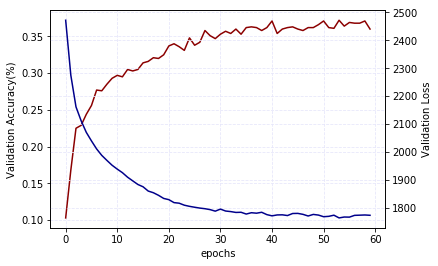

Best Validation Accuracy :  0.372


In [26]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)

# 에포크 숫자만큼 range(epoch)를 변경해주셔야 합니다~
ax_acc.plot(range(60), history['val_acc'], label='정확도(%)', color='darkred')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')
ax_loss = ax_acc.twinx()
ax_loss.plot(range(60), history['val_loss'], label='오차', color='darkblue')
plt.ylabel('Validation Loss')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()

# 최고 validation accuracy는?
print("Best Validation Accuracy : ",max(history['val_acc']))